In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel
np.random.seed(42)
torch.manual_seed(42)
global_dtype = torch.float64
device ='cpu'

### 1. Introduction

---

In this notebook we explore an approximate kernel ridge ression method *Nystrom Kernel Ridge Regression* We apply this method to the same toy example from previous examples 

*As always when reading this notebook it is recommended to collapse all code cells and explore as needed.*

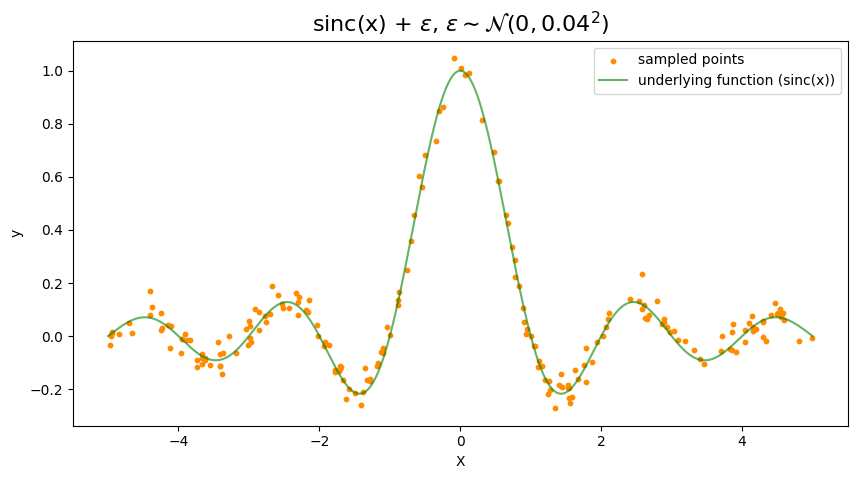

In [51]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 200

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 1000).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


### 2. Nystrom approximation for KRR 
---
As we saw before Kernel Ridge regression suffered from the cubic complexity of kernel inversion. **Nystrom** Kernel Ridge Regression attempts to adress this problem by finding a way to represent the kernel matrix using a subset of training points called *inducing points*

For $m \in \mathbb{N}$, let $z_1, \ldots, z_m \in \mathcal{X}$ be a set of input points based on which we approximate the KRR solution. These points $z_1, \ldots, z_m$ are usually a subset of training input points $x_1, \ldots, x_n$ in the kernel literature, but we allow for $z_1, \ldots, z_m$ to be generic points in $\mathcal{X}$ for a later comparison with the GP counterpart. Write $Z=\left(z_1, \ldots, z_m\right) \in \mathcal{X}^m$. Suppose that the kernel matrix $k_{Z Z}=\left(k\left(z_i, z_j\right)\right)_{i, j=1}^m \in \mathbb{R}^{m \times m}$ is invertible.

Let $M \subset \mathcal{H}_k$ be the finite dimensional subspace spanned by $k\left(\cdot, z_1\right), \ldots, k\left(\cdot, z_m\right)$ :
$$
M:=\operatorname{span}\left(k\left(\cdot, z_1\right), \ldots, k\left(\cdot, z_m\right)\right):=\left\{\sum_{j=1}^m \alpha_j k\left(\cdot, z_j\right) \mid \alpha_1, \ldots, \alpha_m \in \mathbb{R}\right\} .
$$

We replace the hypothesis space $\mathcal{H}_k$ in the KRR objective function by this subspace $M$, and define its solution $\bar{f}$ as the Nyström approximation of the KRR solution $\hat{f}$ :
$$
\bar{f}:=\underset{f \in M}{\arg \min } \frac{1}{n} \sum_{i=1}^n\left(y_i-f\left(x_i\right)\right)^2+\lambda\|f\|_{\mathcal{H}_k}^2 .
$$

In other words, we approximately solve the minimization problem of KRR by searching for the solution of the form
$$
f=\sum_{i=1}^m \beta_i k\left(\cdot, z_i\right)=k_Z(\cdot)^{\top} \beta
$$
for some coefficients $\beta:=\left(\beta_1, \ldots, \beta_m\right)^{\top} \in \mathbb{R}^m$, where $k_Z(\cdot):=\left(k\left(\cdot, z_1\right), \ldots, k\left(\cdot, z_m\right)\right)^{\top}$. Using this expression, the optimization problem now becomes
$$
\min _{\beta \in \mathbb{R}^m} \frac{1}{n}\left\|y-k_{X Z} \beta\right\|^2+\lambda \beta^{\top} k_{Z Z} \beta
$$
where $k_{X Z} \in \mathbb{R}^{n \times m}$ with $\left(k_{X Z}\right)_{i, j}=k\left(x_i, z_j\right)$ and $k_{Z Z} \in \mathbb{R}^{m \times m}$ with $\left(k_{Z Z}\right)_{i, j}=k\left(z_i, z_j\right)$. Taking the first order derivative with respect to $\beta$ leads to the condition
$$
-\frac{2}{n} k_{Z X} y+\frac{2}{n} k_{Z X} k_{X Z} \beta+2 \lambda k_{Z Z} \beta=0
$$
which is satisfied for
$$
\beta=\left(k_{Z X} k_{X Z}+n \lambda k_{Z Z}\right)^{-1} k_{Z X} y .
$$

This leads to the following expression of the Nyström approximation:
$$
\bar{f}(x)=k_Z(x)^{\top}\left(n \lambda k_{Z Z}+k_{Z X} k_{X Z}\right)^{-1} k_{Z X} y .
$$

In [52]:
sigma=.05
_lambda=sigma**2/train_data.shape[0]

num_inducing_points = int(train_data.shape[0] * .1)
print("total inducing points : ",num_inducing_points)
lengthscale = 0.1 

total inducing points :  20


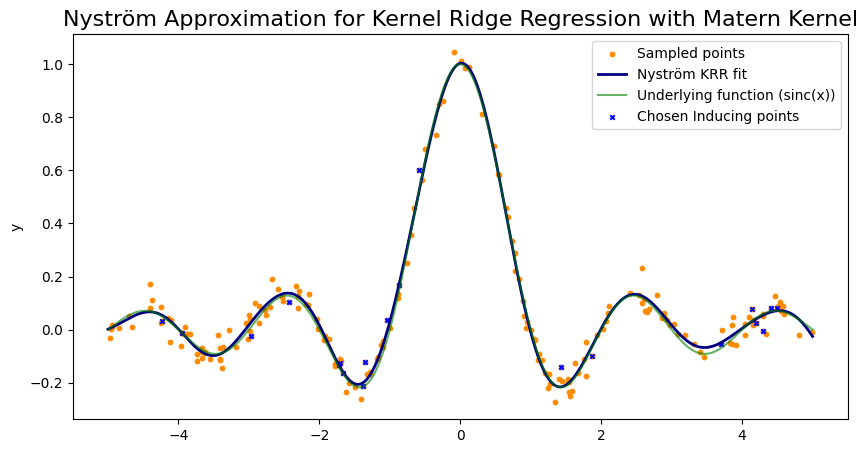

In [56]:
class NystromKRR:
    def __init__(self, _lambda=1.0, lengthscale=0.1, kernel=None, m=10, dtype=global_dtype):
        self._lambda = _lambda
        self.kernel = kernel(nu=1.5,lengthscale=lengthscale)
        self.m = m
        self.dtype = dtype

    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype)
        y = y.to(dtype=self.dtype)
        n = X.shape[0]
        
        indices = np.random.choice(n, self.m, replace=False)

        self.Z = X[indices]

        K_ZZ = self.kernel(self.Z, self.Z).to(dtype=self.dtype)
        K_XZ = self.kernel(X, self.Z).to(dtype=self.dtype)
        K_ZX = K_XZ.T
        
        A = K_ZX @ K_XZ + n * self._lambda * K_ZZ
        b = K_ZX @ y
        self.beta = torch.linalg.solve(A, b)

    def predict(self, X):
        X = X.to(dtype=self.dtype)
        K_XZ = self.kernel(X, self.Z).to(dtype=self.dtype)
        return K_XZ @ self.beta


nystrom_krr = NystromKRR(_lambda=_lambda, lengthscale=lengthscale, m=num_inducing_points, kernel=RBFKernel, dtype=global_dtype)
nystrom_krr.fit(train_data, train_labels)
NKrr_preds = nystrom_krr.predict(test_data)
NKrr_preds = NKrr_preds.detach().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange', s=10, label='Sampled points')
plt.plot(test_data.numpy(), NKrr_preds, color='navy', lw=2, label='Nyström KRR fit')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='Underlying function (sinc(x))')

inducing_indices = np.array([i for i in range(train_data.shape[0]) if np.any(np.isclose(train_data[i].numpy(), nystrom_krr.Z.numpy()))])
inducing_points = train_data[inducing_indices].numpy()
inducing_labels = train_labels[inducing_indices].numpy()
plt.scatter(inducing_points, inducing_labels, color='blue', s=10, label='Chosen Inducing points', marker='x')

plt.ylabel('y')
plt.title(r'Nyström Approximation for Kernel Ridge Regression with Matern Kernel', fontsize=16)
plt.legend()
plt.show()


### 4. Time Complexity

---
What is the operational complexity of running Nyström Kernel Ridge Regression? Here $ m $ represents the number of inducing points used during training while $Y$ denotes the number of test points in inference.

<center>

### Time Complexity of Nyström Kernel Ridge Regression (KRR)

| **Phase**       | **Operation**                                          | **Complexity**          |
|-----------------|--------------------------------------------------------|-------------------------|
| **Fitting**     | Kernel Computation (K_ZZ, K_XZ)                       | $\mathcal{O}(nm^2)$      |
|                 | Matrix Multiplication and Inversion | $\mathcal{O}(m^3 + n m^2)$ |
| **Inference**   | Kernel Computation for Predictions                    | $\mathcal{O}(Y m^2)$    |
|                 | Prediction Computation                                 | $\mathcal{O}(Y m)$      |

</center>

**Summary**:  
- **Fitting**: Dominated by $\mathcal{O}(m^3)$ due to matrix inversion and $\mathcal{O}(nm^2)$ for kernel computations.  
- **Inference**: $\mathcal{O}(n m^2)$ for kernel computation and $\mathcal{O}(n m)$ for prediction computation.

The time complexity of Nyström Kernel Ridge Regression (NystKRR) shows a clear improvement over traditional KRR, particularly for large datasets. In Nyström KRR, the matrix inversion is performed on a smaller subset of data, the Nyström approximating set, which reduces the computational complexity from $\mathcal{O}(n^3)$ in standard KRR to $\mathcal{O}(m^3 + n m^2)$. 



#### 5. Approximation Quality 
---
The quality of Nyström KRR heavily relies on the selection of inducing points, referred to as landmarks when chosen as a subset of the training set, which are used to approximate the kernel matrix. The choice of these inducing points can significantly impact the accuracy of the total approximation. Typically, good inducing points are those that effectively capture the underlying structure of the data. A common approach to selecting these points is to use clustering algorithms such as k-means which becomes more useful in higher dimensions. 

To illustrate the sensitivity of NystKRR consider the following example in which the inducing points are selected to be jut the first $m$ training points



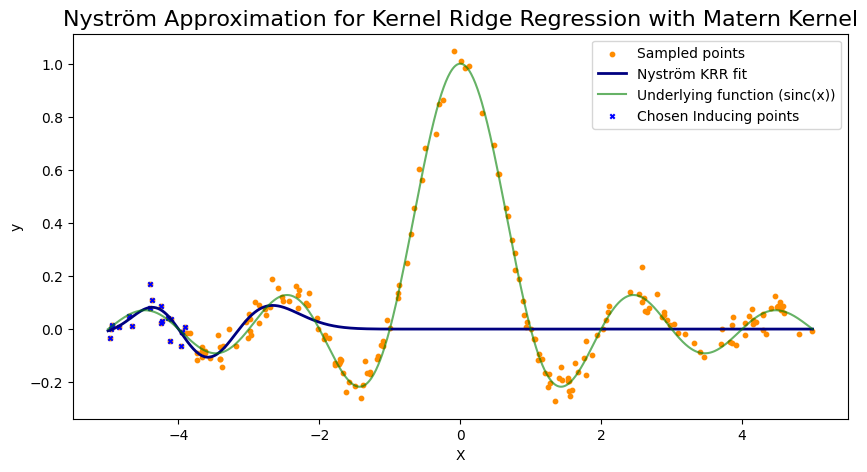

In [58]:
class NystromKRR:
    def __init__(self, _lambda=1.0, lengthscale=0.1, kernel=None, m=10, dtype=global_dtype):
        self._lambda = _lambda
        self.kernel = kernel(nu=1.5,lengthscale=lengthscale)
        self.m = m
        self.dtype = dtype

    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype)
        y = y.to(dtype=self.dtype)
        n = X.shape[0]
        #Pick the smallest m inducing points from X 
        sorted_indices = torch.argsort(self.X_train.squeeze())
        selected_indices = sorted_indices[:self.m]
        self.Z = self.X_train[selected_indices]
        
        K_ZZ = self.kernel(self.Z, self.Z).to(dtype=self.dtype)
        K_XZ = self.kernel(X, self.Z).to(dtype=self.dtype)
        K_ZX = K_XZ.T
        
        A = K_ZX @ K_XZ + n * self._lambda * K_ZZ
        b = K_ZX @ y
        self.beta = torch.linalg.solve(A, b)

    def predict(self, X):
        X = X.to(dtype=self.dtype)
        K_XZ = self.kernel(X, self.Z).to(dtype=self.dtype)
        return K_XZ @ self.beta


nystrom_krr = NystromKRR(_lambda=_lambda, lengthscale=lengthscale, m=num_inducing_points, kernel=RBFKernel, dtype=global_dtype)
nystrom_krr.fit(train_data, train_labels)
NKrr_preds = nystrom_krr.predict(test_data)
NKrr_preds = NKrr_preds.detach().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange', s=10, label='Sampled points')
plt.plot(test_data.numpy(), NKrr_preds, color='navy', lw=2, label='Nyström KRR fit')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='Underlying function (sinc(x))')

inducing_indices = np.array([i for i in range(train_data.shape[0]) if np.any(np.isclose(train_data[i].numpy(), nystrom_krr.Z.numpy()))])
inducing_points = train_data[inducing_indices].numpy()
inducing_labels = train_labels[inducing_indices].numpy()
plt.scatter(inducing_points, inducing_labels, color='blue', s=10, label='Chosen Inducing points', marker='x')

plt.xlabel('X')
plt.ylabel('y')
plt.title(r'Nyström Approximation for Kernel Ridge Regression with Matern Kernel', fontsize=16)
plt.legend()
plt.show()
